# Label-Free Concept Bottleneck Model (LF-CBM) for Brain Scan Classification

This notebook implements an explainable AI approach using BioMedCLIP to classify brain scans based on clinical concepts rather than raw pixels.

**Pipeline:**
1. Load BioMedCLIP pre-trained model
2. Define clinical concept bank
3. Extract image-text similarity scores
4. Train logistic regression on concept scores
5. Analyze concept importance for explainability

## Step 1: Install Required Packages

First, let's install the necessary packages for BioMedCLIP.

## Step 2: Import Libraries and Setup Device

In [1]:
import torch
import torch.nn.functional as F
import open_clip
from PIL import Image
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(1)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(1).total_memory / 1e9:.2f} GB")

/home/group2/youssef/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.30 GB


## Step 3: Load BioMedCLIP Model

Load the pre-trained BioMedCLIP model from Microsoft.

In [2]:
print("Loading BioMedCLIP model...")
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'

# Load model using open_clip (the correct way for BiomedCLIP)
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

# Move model to device
model = model.to(device)
model.eval()

print(f"✓ BioMedCLIP model loaded successfully on {device}")

Loading BioMedCLIP model...
✓ BioMedCLIP model loaded successfully on cuda:1


## Step 4: Define Clinical Concept Bank

Define the clinical concepts for each condition that will serve as our interpretable features.

### Dataset Visual Analysis Results

Before defining concepts, let's review the visual characteristics of your dataset:

**Hemorrhagic Images:**
- Primary sequences: SWI (77%), DWI (14%), GRE (8%)
- Average brightness: 0.258 (moderate)
- Key features: Dark signals, blooming artifacts, well-defined boundaries

**Ischemic Images:**
- Primary sequences: Mixed/DWI-based
- Average brightness: 0.194 (darkest class)
- Key features: Territorial patterns, diffusion restriction, wedge-shaped lesions

**Tumor Images:**
- Various MRI sequences
- Average brightness: 0.301 (brightest class)
- Key features: Mass effect, irregular margins, heterogeneous signals

These observations inform our concept selection below.

In [3]:
# Define clinical concepts for each class
# These concepts are specifically tailored to this dataset based on visual analysis
# Dataset characteristics:
# - Hemorrhagic: 77% SWI, 14% DWI, 8% GRE | Brightness: 0.258, Contrast: 0.313
# - Ischemic: Mixed sequences (73% unlabeled), 17% DWI | Brightness: 0.194 (darkest), Contrast: 0.225
# - Tumor: Various contrasts | Brightness: 0.301 (brightest), Edge Density: 0.0414 (highest)

concept_bank = {
    "Tumor": [
        "space-occupying lesion",
        "mass effect present",
        "irregular lesion margins",
        "vasogenic edema pattern",
        "central hypointensity",
        "heterogeneous signal intensity",
        "fingerlike edema extension",
        "structural displacement",
        "necrotic center"
    ],
    "Hemorrhagic": [
        "dark signal on susceptibility weighted imaging",
        "blooming artifact present",
        "focal hypointense region",
        "blood products signal intensity",
        "susceptibility artifact",
        "well-circumscribed hemorrhagic lesion",
        "acute bleeding pattern",
        "hypointense on SWI"
    ],
    "Ischemic": [
        "bright signal on diffusion weighted imaging",
        "territorial distribution pattern",
        "vascular territory involvement",
        "diffusion restriction present",
        "wedge-shaped lesion",
        "cortical gray matter involvement",
        "hypointense region on apparent diffusion coefficient",
        "acute infarct pattern"
    ]
}

# Flatten all concepts into a single list
all_concepts = []
concept_to_class = {}
for class_name, concepts in concept_bank.items():
    for concept in concepts:
        all_concepts.append(concept)
        concept_to_class[concept] = class_name

print(f"Total concepts: {len(all_concepts)}")
print("\nDataset-Specific Concept Bank:")
print("(Based on analysis of your processed images)\n")
for class_name, concepts in concept_bank.items():
    print(f"\n{class_name} ({len(concepts)} concepts):")
    for concept in concepts:
        print(f"  - {concept}")

Total concepts: 25

Dataset-Specific Concept Bank:
(Based on analysis of your processed images)


Tumor (9 concepts):
  - space-occupying lesion
  - mass effect present
  - irregular lesion margins
  - vasogenic edema pattern
  - central hypointensity
  - heterogeneous signal intensity
  - fingerlike edema extension
  - structural displacement
  - necrotic center

Hemorrhagic (8 concepts):
  - dark signal on susceptibility weighted imaging
  - blooming artifact present
  - focal hypointense region
  - blood products signal intensity
  - susceptibility artifact
  - well-circumscribed hemorrhagic lesion
  - acute bleeding pattern
  - hypointense on SWI

Ischemic (8 concepts):
  - bright signal on diffusion weighted imaging
  - territorial distribution pattern
  - vascular territory involvement
  - diffusion restriction present
  - wedge-shaped lesion
  - cortical gray matter involvement
  - hypointense region on apparent diffusion coefficient
  - acute infarct pattern


## Step 5: Prepare Text Embeddings

Pre-compute text embeddings for all concepts to speed up the feature extraction process.

In [4]:
print("Computing text embeddings for all concepts...")

# Tokenize all concepts using open_clip tokenizer
text_inputs = tokenizer(all_concepts).to(device)

# Get text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_inputs)
    text_embeddings = F.normalize(text_embeddings, dim=-1)

print(f"✓ Text embeddings shape: {text_embeddings.shape}")
print(f"  ({text_embeddings.shape[0]} concepts × {text_embeddings.shape[1]} dimensions)")

Computing text embeddings for all concepts...
✓ Text embeddings shape: torch.Size([25, 512])
  (25 concepts × 512 dimensions)


## Step 6: Load Dataset

Load all processed images from the dataset directories.

In [5]:
# Define dataset path
data_dir = Path("../content/processed_data")

# Class mapping
class_names = ["Hemorrhagic", "Ischemic", "Tumor"]
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = data_dir / class_name
    if not class_dir.exists():
        print(f"Warning: Directory {class_dir} not found!")
        continue
    
    # Get all image files
    image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    
    for img_path in image_files:
        image_paths.append(str(img_path))
        labels.append(class_to_idx[class_name])
    
    print(f"{class_name}: {len(image_files)} images")

print(f"\nTotal images: {len(image_paths)}")
print(f"Labels distribution: {np.bincount(labels)}")

Hemorrhagic: 83 images
Ischemic: 113 images
Tumor: 115 images

Total images: 311
Labels distribution: [ 83 113 115]


## Step 7: Extract Image-Text Similarity Features

For each image, compute similarity scores with all clinical concepts using BioMedCLIP.

In [6]:
def extract_concept_features(image_path, text_embeddings, model, preprocess, device):
    """
    Extract concept-based features for a single image.
    Returns similarity scores between the image and all concepts.
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    # Get image embedding
    with torch.no_grad():
        image_embedding = model.encode_image(image_input)
        image_embedding = F.normalize(image_embedding, dim=-1)
    
    # Compute similarity with all concepts (cosine similarity via dot product)
    similarities = (image_embedding @ text_embeddings.T).squeeze(0)
    
    return similarities.cpu().numpy()

# Extract features for all images
print("Extracting concept features from images...")
print("This may take a few minutes depending on dataset size...\n")

X_features = []
y_labels = []

for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Processing images"):
    try:
        features = extract_concept_features(img_path, text_embeddings, model, preprocess_val, device)
        X_features.append(features)
        y_labels.append(label)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

# Convert to numpy arrays
X = np.array(X_features)
y = np.array(y_labels)

print(f"\n✓ Feature extraction complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"  ({X.shape[0]} images × {X.shape[1]} concept scores)")
print(f"Labels shape: {y.shape}")

Extracting concept features from images...
This may take a few minutes depending on dataset size...



Processing images: 100%|██████████| 311/311 [00:02<00:00, 135.09it/s]


✓ Feature extraction complete!
Feature matrix shape: (311, 25)
  (311 images × 25 concept scores)
Labels shape: (311,)


## Step 8: Train-Test Split

Split the concept features into training and testing sets.

In [20]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")
print(f"\nTraining labels distribution: {np.bincount(y_train)}")
print(f"Testing labels distribution: {np.bincount(y_test)}")

Training set: 248 images
Testing set: 63 images

Training labels distribution: [66 90 92]
Testing labels distribution: [17 23 23]


## Step 9: Train Concept Bottleneck Model

Train a logistic regression classifier on the concept scores.

In [8]:
print("Training Logistic Regression on concept scores...\n")

# Train logistic regression classifier
clf = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0
)

clf.fit(X_train, y_train)

# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✓ Training complete!")
print(f"\n{'='*50}")
print(f"MODEL PERFORMANCE")
print(f"{'='*50}")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*50}")

Training Logistic Regression on concept scores...

✓ Training complete!

MODEL PERFORMANCE
Training Accuracy: 0.9234 (92.34%)
Testing Accuracy:  0.9048 (90.48%)


/home/group2/youssef/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Step 10: Detailed Classification Report

View detailed metrics for each class.

In [9]:
print("\nClassification Report (Test Set):")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)


Classification Report (Test Set):
              precision    recall  f1-score   support

 Hemorrhagic       0.93      0.82      0.88        17
    Ischemic       0.91      0.91      0.91        23
       Tumor       0.88      0.96      0.92        23

    accuracy                           0.90        63
   macro avg       0.91      0.90      0.90        63
weighted avg       0.91      0.90      0.90        63


Confusion Matrix:
[[14  2  1]
 [ 0 21  2]
 [ 1  0 22]]


## Step 11: Visualize Confusion Matrix

Create a visual representation of the confusion matrix.

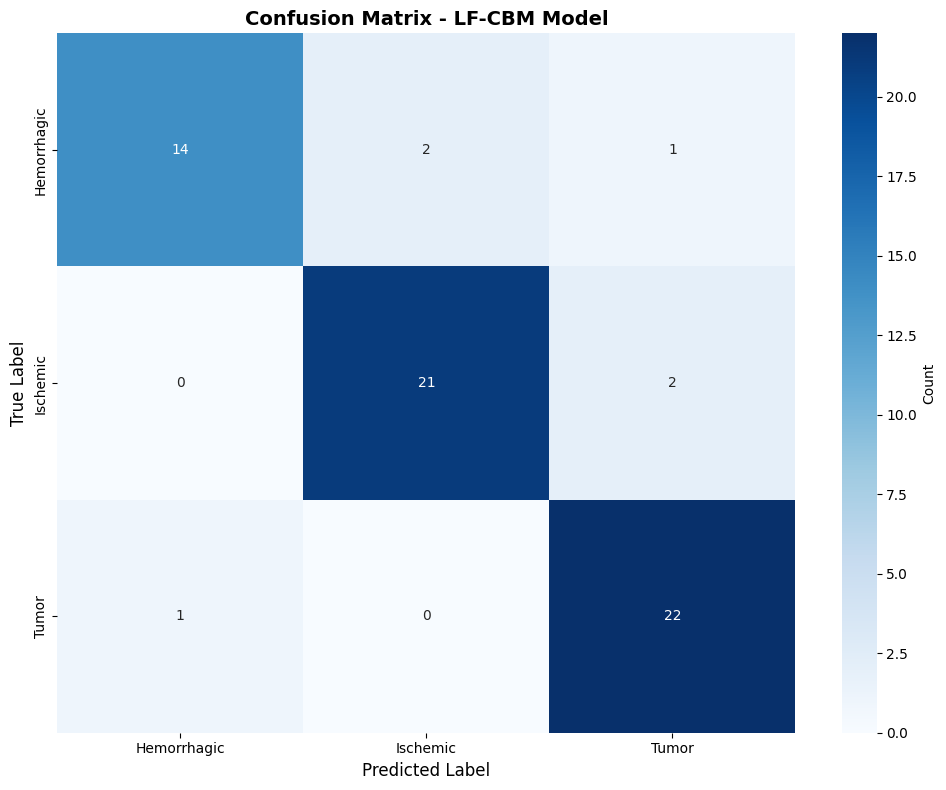

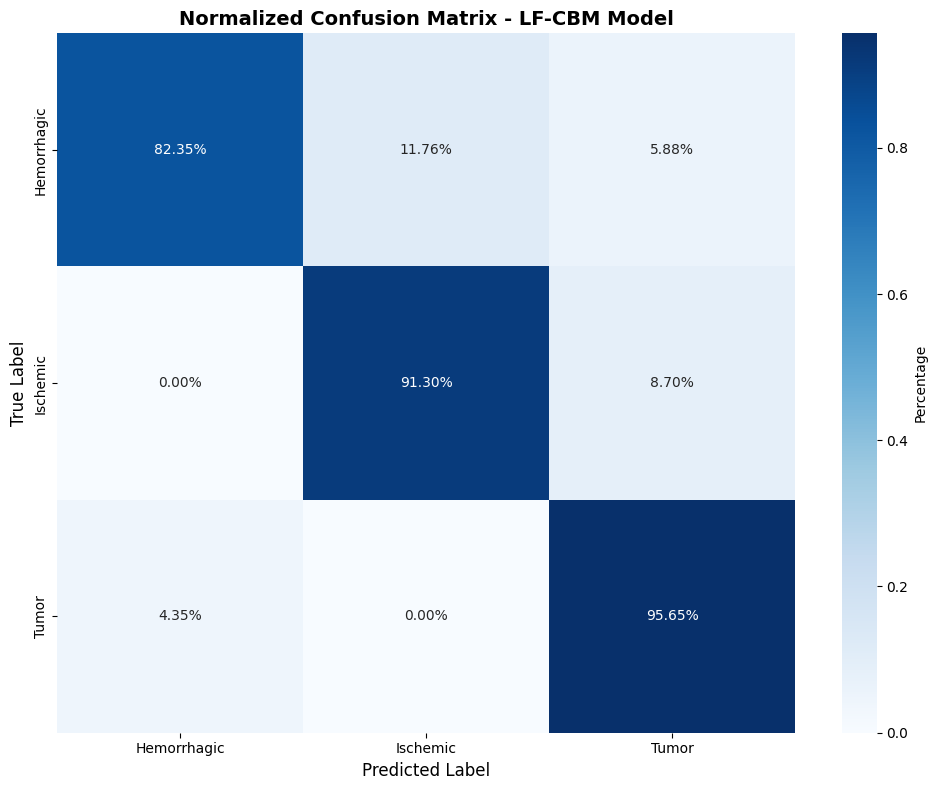

In [10]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LF-CBM Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - LF-CBM Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## Step 12: Explainability - Concept Importance Analysis

Analyze which concepts are most important for each class prediction.

In [11]:
# Extract weights from logistic regression
weights = clf.coef_  # Shape: (n_classes, n_concepts)
print(f"Model weights shape: {weights.shape}")
print(f"  ({weights.shape[0]} classes × {weights.shape[1]} concepts)\n")

# Create DataFrame for better visualization
concept_importance = pd.DataFrame(
    weights.T,
    columns=class_names,
    index=all_concepts
)

print("="*80)
print("CONCEPT WEIGHTS FOR EACH CLASS")
print("="*80)
print("\nPositive weights indicate concepts that support the class prediction.")
print("Negative weights indicate concepts that oppose the class prediction.\n")

for class_name in class_names:
    print(f"\n{'='*80}")
    print(f"TOP CONCEPTS FOR: {class_name.upper()}")
    print(f"{'='*80}")
    
    # Sort concepts by absolute weight
    sorted_concepts = concept_importance[class_name].abs().sort_values(ascending=False)
    
    print(f"\nTop 10 Most Important Concepts (by absolute weight):\n")
    for i, (concept, _) in enumerate(sorted_concepts.head(10).items(), 1):
        weight = concept_importance.loc[concept, class_name]
        impact = "Supporting" if weight > 0 else "Opposing"
        print(f"{i:2d}. {concept:35s} | Weight: {weight:+7.4f} | {impact}")
    
    print(f"\n{'-'*80}")
    print("Top 5 Supporting Concepts (highest positive weights):\n")
    top_positive = concept_importance[class_name].sort_values(ascending=False).head(5)
    for i, (concept, weight) in enumerate(top_positive.items(), 1):
        print(f"{i}. {concept:35s} | Weight: {weight:+7.4f}")
    
    print(f"\n{'-'*80}")
    print("Top 5 Opposing Concepts (most negative weights):\n")
    top_negative = concept_importance[class_name].sort_values(ascending=True).head(5)
    for i, (concept, weight) in enumerate(top_negative.items(), 1):
        print(f"{i}. {concept:35s} | Weight: {weight:+7.4f}")

Model weights shape: (3, 25)
  (3 classes × 25 concepts)

CONCEPT WEIGHTS FOR EACH CLASS

Positive weights indicate concepts that support the class prediction.
Negative weights indicate concepts that oppose the class prediction.


TOP CONCEPTS FOR: HEMORRHAGIC

Top 10 Most Important Concepts (by absolute weight):

 1. dark signal on susceptibility weighted imaging | Weight: +2.0787 | Supporting
 2. susceptibility artifact             | Weight: +1.8907 | Supporting
 3. hypointense on SWI                  | Weight: +1.4191 | Supporting
 4. diffusion restriction present       | Weight: -1.3457 | Opposing
 5. wedge-shaped lesion                 | Weight: -1.3424 | Opposing
 6. cortical gray matter involvement    | Weight: -0.9159 | Opposing
 7. vasogenic edema pattern             | Weight: -0.8547 | Opposing
 8. well-circumscribed hemorrhagic lesion | Weight: -0.7395 | Opposing
 9. territorial distribution pattern    | Weight: +0.7087 | Supporting
10. central hypointensity               | 

## Step 13: Visualize Concept Importance

Create heatmaps to visualize which concepts are important for each class.

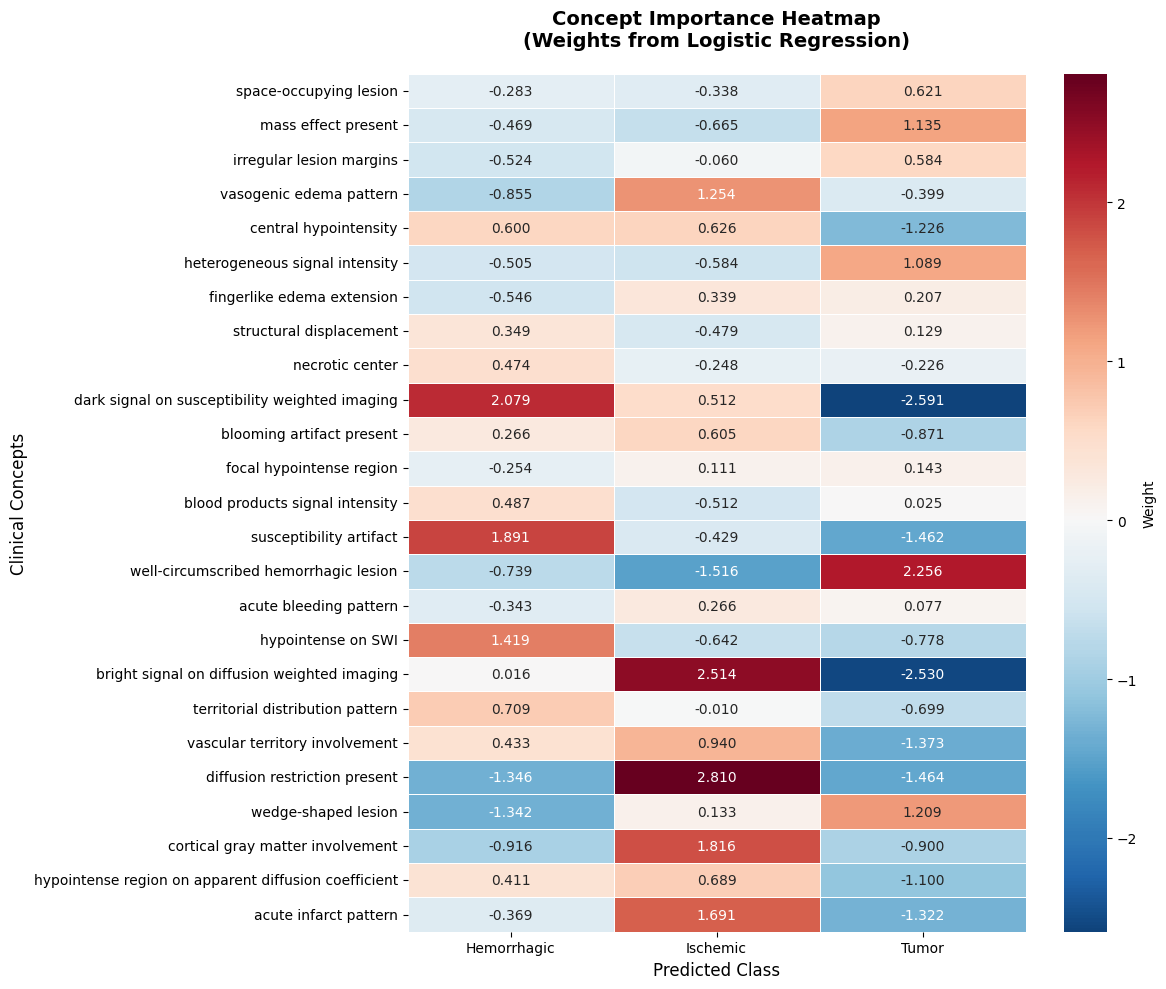

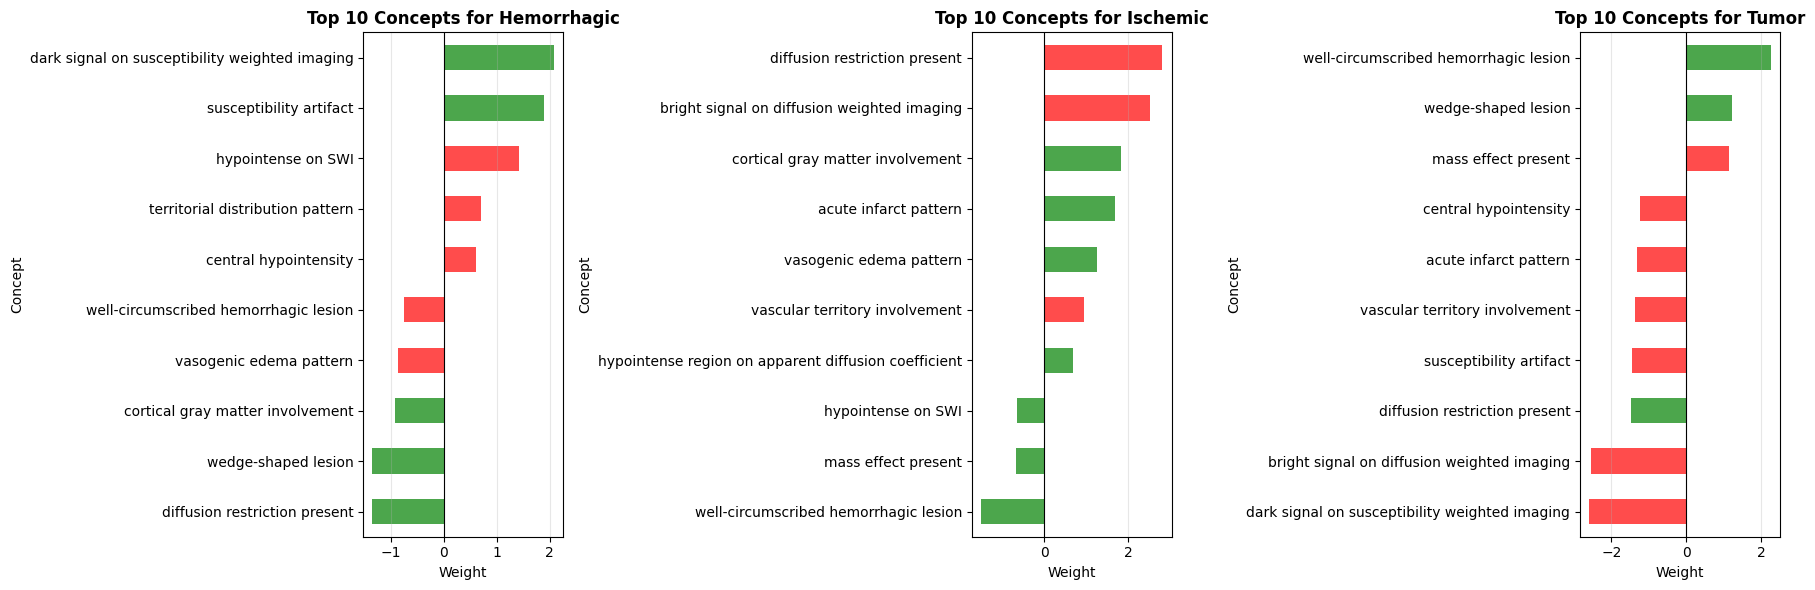

In [12]:
# Heatmap of all concept weights
plt.figure(figsize=(12, 10))
sns.heatmap(concept_importance, cmap='RdBu_r', center=0, 
            annot=True, fmt='.3f', linewidths=0.5,
            cbar_kws={'label': 'Weight'})
plt.title('Concept Importance Heatmap\n(Weights from Logistic Regression)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Clinical Concepts', fontsize=12)
plt.tight_layout()
plt.show()

# Bar plot for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, class_name in enumerate(class_names):
    ax = axes[idx]
    
    # Get top 10 concepts by absolute weight
    top_concepts = concept_importance[class_name].abs().sort_values(ascending=False).head(10)
    top_concepts_signed = concept_importance.loc[top_concepts.index, class_name]
    
    # Create color based on sign
    colors = ['green' if w > 0 else 'red' for w in top_concepts_signed]
    
    # Plot
    top_concepts_signed.sort_values().plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_title(f'Top 10 Concepts for {class_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Weight', fontsize=10)
    ax.set_ylabel('Concept', fontsize=10)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 14: Example Prediction with Explanation

Demonstrate how to make a prediction with concept-based explanation.

In [ ]:
def explain_prediction(image_path, model, preprocess, text_embeddings, 
                      clf, all_concepts, class_names, device, top_k=5):
    """
    Make a prediction and explain it using concept scores.
    """
    # Extract concept features
    features = extract_concept_features(image_path, text_embeddings, model, 
                                       preprocess, device)
    
    # Make prediction
    prediction = clf.predict(features.reshape(1, -1))[0]
    probabilities = clf.predict_proba(features.reshape(1, -1))[0]
    predicted_class = class_names[prediction]
    
    print("="*80)
    print(f"PREDICTION EXPLANATION FOR: {image_path}")
    print("="*80)
    print(f"\n🔍 Predicted Class: {predicted_class}")
    print(f"\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        prob = probabilities[i]
        bar = '█' * int(prob * 50)
        print(f"  {class_name:15s}: {prob:.4f} ({prob*100:.2f}%) {bar}")
    
    print(f"\n{'='*80}")
    print(f"CONCEPT ACTIVATION SCORES")
    print(f"{'='*80}")
    print("\nHighest Activated Concepts (indicating presence):\n")
    
    # Get top activated concepts
    concept_scores = pd.Series(features, index=all_concepts)
    top_activated = concept_scores.sort_values(ascending=False).head(top_k)
    
    for i, (concept, score) in enumerate(top_activated.items(), 1):
        # Get weight for predicted class
        concept_idx = all_concepts.index(concept)
        weight = clf.coef_[prediction, concept_idx]
        contribution = score * weight
        
        print(f"{i}. {concept:35s}")
        print(f"   Similarity Score: {score:.4f}")
        print(f"   Weight for {predicted_class}: {weight:+.4f}")
        print(f"   Contribution: {contribution:+.4f}")
        print()
    
    print(f"{'='*80}")
    print(f"INTERPRETATION")
    print(f"{'='*80}")
    print(f"\nThe model predicted '{predicted_class}' based on the following reasoning:")
    print(f"\nTop supporting evidence:")
    
    # Find concepts with high score AND high positive weight for predicted class
    contributions = []
    for i, concept in enumerate(all_concepts):
        score = features[i]
        weight = clf.coef_[prediction, i]
        contrib = score * weight
        contributions.append((concept, score, weight, contrib))
    
    # Sort by contribution
    contributions.sort(key=lambda x: x[3], reverse=True)
    
    for i, (concept, score, weight, contrib) in enumerate(contributions[:3], 1):
        if contrib > 0:
            print(f"{i}. Detected '{concept}' (similarity: {score:.3f}, weight: {weight:+.3f})")
    
    return prediction, probabilities, features

# Test on a random sample from test set
test_idx = np.random.randint(0, len(X_test))
test_image_path = image_paths[test_idx]
true_label = class_names[y[test_idx]]

print(f"Testing on image from: {test_image_path}")
print(f"True label: {true_label}\n")

prediction, probs, features = explain_prediction(
    test_image_path, model, preprocess_val, text_embeddings,
    clf, all_concepts, class_names, device, top_k=5
)

../content/processed_data/Hemorrhagic/Venda_DWI-14.jpg_Haemorrhagic_65.png
Testing on image from: ../content/processed_data/Tumor/image(92).jpg
True label: Hemorrhagic

PREDICTION EXPLANATION FOR: ../content/processed_data/Tumor/image(92).jpg

🔍 Predicted Class: Tumor

Class Probabilities:
  Hemorrhagic    : 0.2283 (22.83%) ███████████
  Ischemic       : 0.1183 (11.83%) █████
  Tumor          : 0.6534 (65.34%) ████████████████████████████████

CONCEPT ACTIVATION SCORES

Highest Activated Concepts (indicating presence):

1. space-occupying lesion             
   Similarity Score: 0.4343
   Weight for Tumor: +0.6211
   Contribution: +0.2697

2. blooming artifact present          
   Similarity Score: 0.3806
   Weight for Tumor: -0.8706
   Contribution: -0.3313

3. heterogeneous signal intensity     
   Similarity Score: 0.3733
   Weight for Tumor: +1.0893
   Contribution: +0.4067

4. central hypointensity              
   Similarity Score: 0.3630
   Weight for Tumor: -1.2262
   Contribut

## Step 15: Save the Model

Save the trained model and concept bank for future use.

In [14]:
import pickle
import json

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the logistic regression model
model_path = "../models/lfcbm_classifier.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"✓ Saved classifier to: {model_path}")

# Save the concept bank and metadata
metadata = {
    "concept_bank": concept_bank,
    "all_concepts": all_concepts,
    "class_names": class_names,
    "class_to_idx": class_to_idx,
    "model_name": model_name,
    "test_accuracy": float(test_acc),
    "train_accuracy": float(train_acc)
}

metadata_path = "../models/lfcbm_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata to: {metadata_path}")

# Save concept importance
importance_path = "../models/lfcbm_concept_importance.csv"
concept_importance.to_csv(importance_path)
print(f"✓ Saved concept importance to: {importance_path}")

print(f"\n{'='*80}")
print("MODEL SAVED SUCCESSFULLY")
print(f"{'='*80}")
print("\nYou can now load and use this model for inference with explainability!")

✓ Saved classifier to: ../models/lfcbm_classifier.pkl
✓ Saved metadata to: ../models/lfcbm_metadata.json
✓ Saved concept importance to: ../models/lfcbm_concept_importance.csv

MODEL SAVED SUCCESSFULLY

You can now load and use this model for inference with explainability!


In [21]:
# Save model in .pth format (PyTorch format) for consistency
import torch

# Create a dictionary with all necessary components
model_state = {
    'classifier': clf,  # sklearn LogisticRegression model
    'concept_bank': concept_bank,
    'all_concepts': all_concepts,
    'class_names': class_names,
    'class_to_idx': class_to_idx,
    'model_name': model_name,
    'test_accuracy': float(test_acc),
    'train_accuracy': float(train_acc),
    'concept_importance': concept_importance,
    'weights': clf.coef_,
    'intercept': clf.intercept_
}

# Save in PyTorch format
model_path_pth = "../models/lfcbm_model.pth"
torch.save(model_state, model_path_pth)
print(f"✓ Saved complete model to: {model_path_pth}")

print(f"\n{'='*80}")
print("MODEL SAVED IN .PTH FORMAT")
print(f"{'='*80}")
print("\nModel components saved:")
print("  - Logistic Regression classifier")
print("  - Concept bank and metadata")
print("  - Model weights and intercepts")
print("  - Concept importance DataFrame")
print("  - Performance metrics")
print("\nTo load the model:")
print("  model_state = torch.load('lfcbm_model.pth')")
print("  clf = model_state['classifier']")
print(f"{'='*80}")

✓ Saved complete model to: ../models/lfcbm_model.pth

MODEL SAVED IN .PTH FORMAT

Model components saved:
  - Logistic Regression classifier
  - Concept bank and metadata
  - Model weights and intercepts
  - Concept importance DataFrame
  - Performance metrics

To load the model:
  model_state = torch.load('lfcbm_model.pth')
  clf = model_state['classifier']


In [23]:
# Sanity check: Load and test both .pkl and .pth models
print("="*80)
print("SANITY CHECK: Testing .pkl vs .pth model")
print("="*80)

# 1. Load the .pkl model
print("\n[1] Loading .pkl model...")
with open("../models/lfcbm_classifier.pkl", 'rb') as f:
    clf_pkl = pickle.load(f)
print("✓ .pkl model loaded")

# 2. Load the .pth model
print("\n[2] Loading .pth model...")
# Set weights_only=False since we're loading sklearn model (trusted source)
model_state_pth = torch.load("../models/lfcbm_model.pth", weights_only=False)
clf_pth = model_state_pth['classifier']
print("✓ .pth model loaded")
print(f"   .pth model contains keys: {list(model_state_pth.keys())}")

# 3. Select a random test image
print("\n[3] Selecting test image...")
test_idx = np.random.randint(0, len(X_test))
test_image_path = [p for i, p in enumerate(image_paths) if i < len(y) and y[i] in y_test][test_idx]
true_label_idx = y[image_paths.index(test_image_path)]
true_label = class_names[true_label_idx]
print(f"   Image: {test_image_path}")
print(f"   True label: {true_label}")

# 4. Extract features (same for both models)
print("\n[4] Extracting concept features...")
features = extract_concept_features(test_image_path, text_embeddings, model, preprocess_val, device)
print(f"   Features shape: {features.shape}")

# 5. Test .pkl model
print("\n[5] Testing .pkl model prediction...")
pred_pkl = clf_pkl.predict(features.reshape(1, -1))[0]
prob_pkl = clf_pkl.predict_proba(features.reshape(1, -1))[0]
print(f"   Prediction: {class_names[pred_pkl]}")
print(f"   Probabilities: {prob_pkl}")

# 6. Test .pth model
print("\n[6] Testing .pth model prediction...")
pred_pth = clf_pth.predict(features.reshape(1, -1))[0]
prob_pth = clf_pth.predict_proba(features.reshape(1, -1))[0]
print(f"   Prediction: {class_names[pred_pth]}")
print(f"   Probabilities: {prob_pth}")

# 7. Compare results
print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)
print(f"\nTrue Label:        {true_label}")
print(f".pkl Prediction:   {class_names[pred_pkl]}")
print(f".pth Prediction:   {class_names[pred_pth]}")
print(f"\nPredictions match: {pred_pkl == pred_pth} ✓" if pred_pkl == pred_pth else f"\nPredictions match: {pred_pkl == pred_pth} ✗")
print(f"Probabilities match: {np.allclose(prob_pkl, prob_pth)} ✓" if np.allclose(prob_pkl, prob_pth) else f"Probabilities match: {np.allclose(prob_pkl, prob_pth)} ✗")

# Show probability differences
print("\nProbability Comparison:")
print(f"{'Class':<15} {'PKL':>10} {'PTH':>10} {'Diff':>10}")
print("-" * 50)
for i, cls in enumerate(class_names):
    diff = abs(prob_pkl[i] - prob_pth[i])
    print(f"{cls:<15} {prob_pkl[i]:>10.6f} {prob_pth[i]:>10.6f} {diff:>10.2e}")

print("\n" + "="*80)
if pred_pkl == pred_pth and np.allclose(prob_pkl, prob_pth):
    print("✓ SANITY CHECK PASSED: Both models produce identical results!")
else:
    print("✗ SANITY CHECK FAILED: Models produce different results!")
print("="*80)

SANITY CHECK: Testing .pkl vs .pth model

[1] Loading .pkl model...
✓ .pkl model loaded

[2] Loading .pth model...
✓ .pth model loaded
   .pth model contains keys: ['classifier', 'concept_bank', 'all_concepts', 'class_names', 'class_to_idx', 'model_name', 'test_accuracy', 'train_accuracy', 'concept_importance', 'weights', 'intercept']

[3] Selecting test image...
   Image: ../content/processed_data/Hemorrhagic/Manjula_SWI-53.jpg_Haemorrhagic_135.png
   True label: Hemorrhagic

[4] Extracting concept features...
   Features shape: (25,)

[5] Testing .pkl model prediction...
   Prediction: Hemorrhagic
   Probabilities: [0.44607115 0.25195384 0.30197501]

[6] Testing .pth model prediction...
   Prediction: Hemorrhagic
   Probabilities: [0.44607115 0.25195384 0.30197501]

COMPARISON RESULTS

True Label:        Hemorrhagic
.pkl Prediction:   Hemorrhagic
.pth Prediction:   Hemorrhagic

Predictions match: True ✓
Probabilities match: True ✓

Probability Comparison:
Class                  PKL  

ADDITIONAL MODEL PERFORMANCE VISUALIZATIONS

[1] Computing ROC curves...


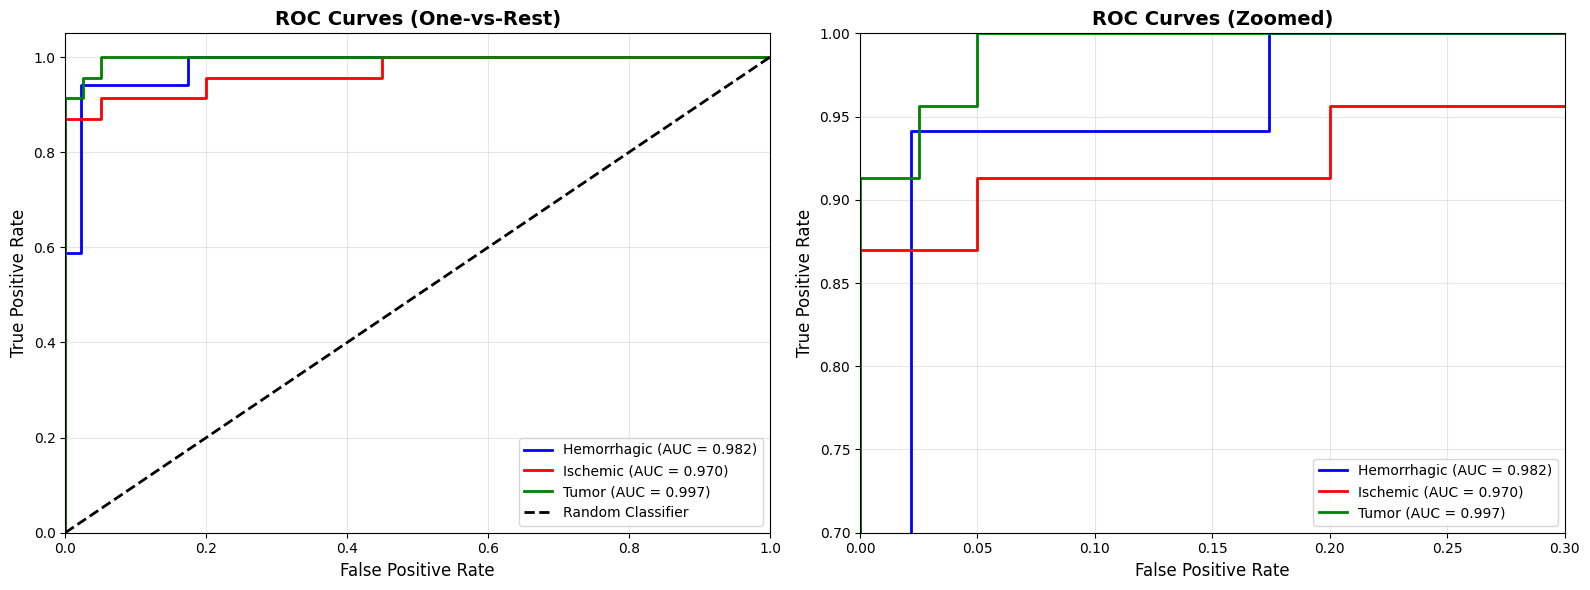


ROC AUC Scores:
----------------------------------------
Hemorrhagic    : 0.9821
Ischemic       : 0.9696
Tumor          : 0.9967

Macro-average AUC:    0.9828
Weighted-average AUC: 0.9829

[2] Computing Precision-Recall curves...


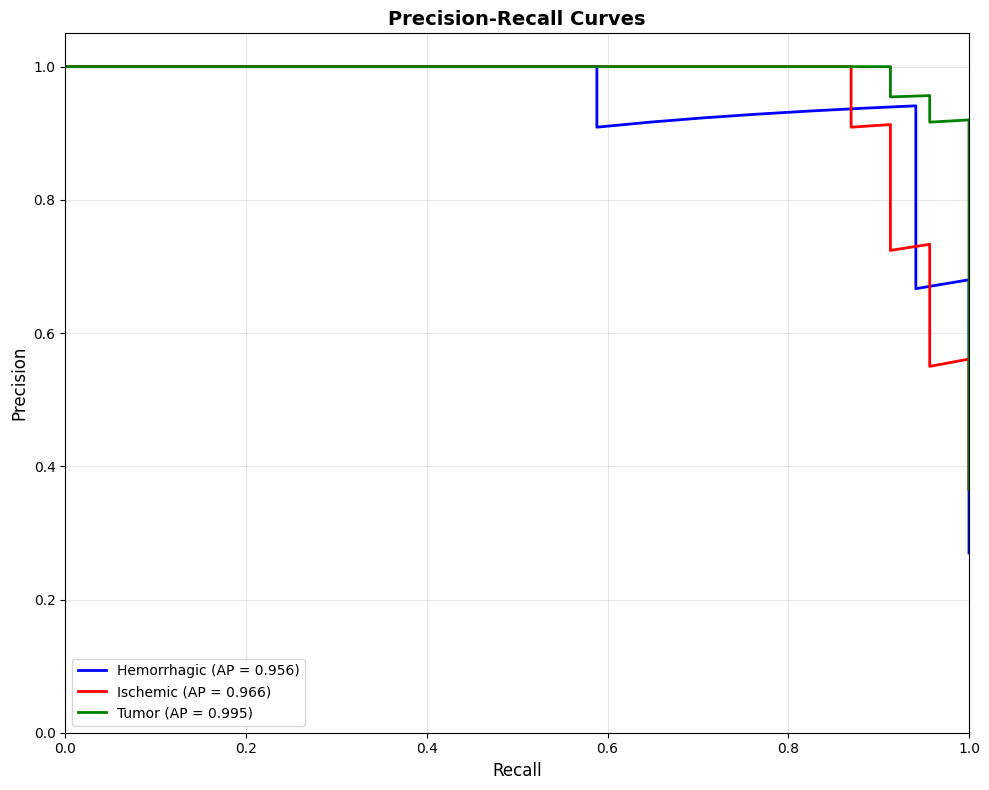


Average Precision Scores:
----------------------------------------
Hemorrhagic    : 0.9565
Ischemic       : 0.9655
Tumor          : 0.9946

[3] Creating per-class metrics visualization...


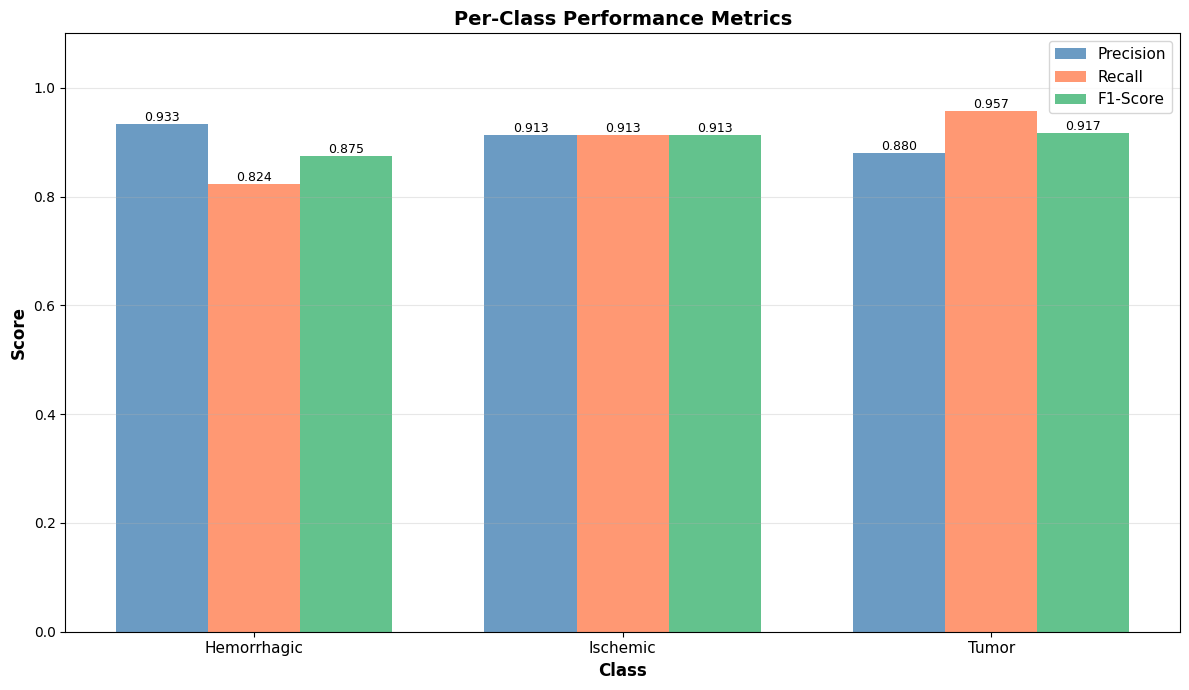


Per-Class Metrics Summary:
------------------------------------------------------------
Class           Precision    Recall       F1-Score    
------------------------------------------------------------
Hemorrhagic     0.9333       0.8235       0.8750      
Ischemic        0.9130       0.9130       0.9130      
Tumor           0.8800       0.9565       0.9167      
------------------------------------------------------------
Macro Avg       0.9088       0.8977       0.9016      
Weighted Avg    0.9065       0.9048       0.9041      
------------------------------------------------------------

[4] Analyzing prediction confidence...


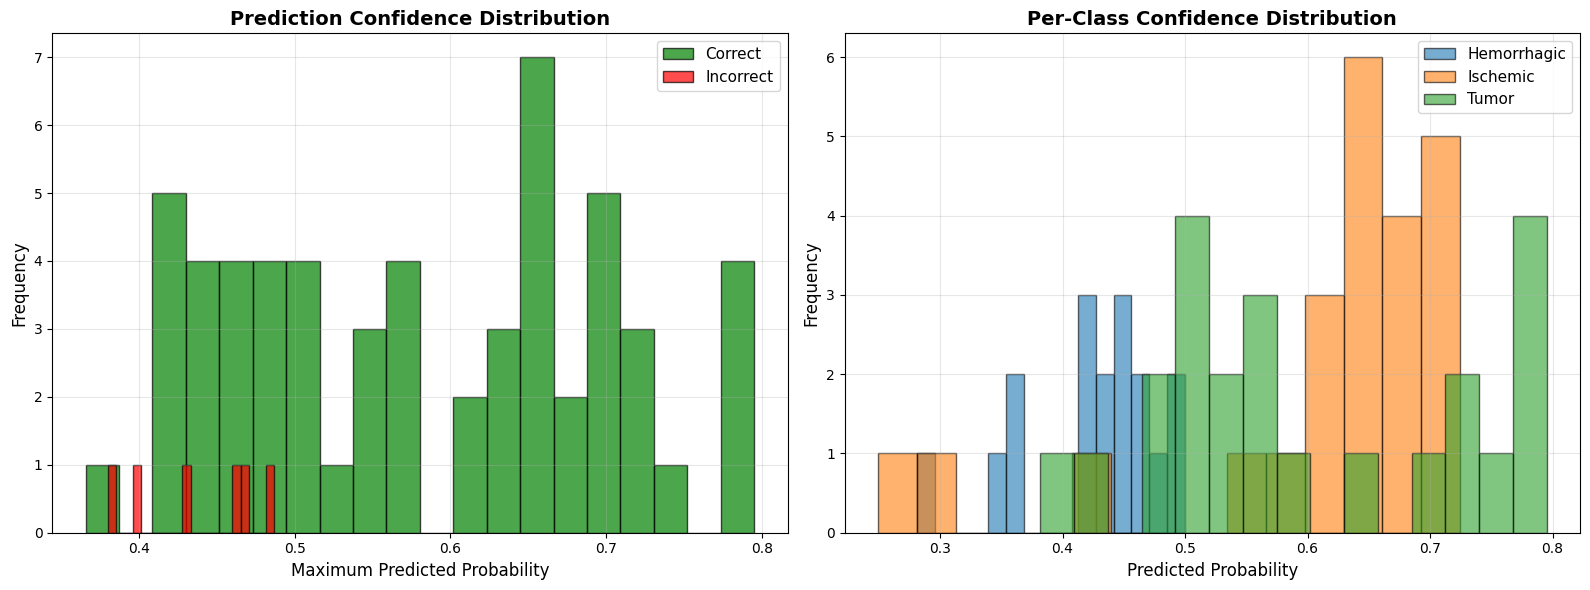


Confidence Statistics:
------------------------------------------------------------
Mean confidence (correct):   0.5815
Mean confidence (incorrect): 0.4377
Overall mean confidence:     0.5678

PERFORMANCE ANALYSIS COMPLETE


In [24]:
# Additional Performance Visualizations
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

print("="*80)
print("ADDITIONAL MODEL PERFORMANCE VISUALIZATIONS")
print("="*80)

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = len(class_names)

# Get predicted probabilities for test set
y_score = clf.predict_proba(X_test)

# ============================================================================
# 1. ROC CURVES (One-vs-Rest)
# ============================================================================
print("\n[1] Computing ROC curves...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Individual ROC curves
ax = axes[0]
colors = ['blue', 'red', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, 
            label=f'{class_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Zoomed-in view (top-left corner)
ax = axes[1]
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, 
            label=f'{class_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
ax.set_xlim([0.0, 0.3])
ax.set_ylim([0.7, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves (Zoomed)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print AUC scores
print("\nROC AUC Scores:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_name:15s}: {roc_auc:.4f}")

# Macro and micro averages
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_test_bin, y_score, average='macro')
weighted_auc = roc_auc_score(y_test_bin, y_score, average='weighted')
print(f"\nMacro-average AUC:    {macro_auc:.4f}")
print(f"Weighted-average AUC: {weighted_auc:.4f}")

# ============================================================================
# 2. PRECISION-RECALL CURVES
# ============================================================================
print("\n[2] Computing Precision-Recall curves...")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, (class_name, color) in enumerate(zip(class_names, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    ax.plot(recall, precision, color=color, lw=2,
            label=f'{class_name} (AP = {avg_precision:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print Average Precision scores
print("\nAverage Precision Scores:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    print(f"{class_name:15s}: {avg_precision:.4f}")

# ============================================================================
# 3. PER-CLASS METRICS BAR CHART
# ============================================================================
print("\n[3] Creating per-class metrics visualization...")

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics per class
precisions = precision_score(y_test, y_test_pred, average=None)
recalls = recall_score(y_test, y_test_pred, average=None)
f1_scores = f1_score(y_test, y_test_pred, average=None)

# Create bar chart
x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width, precisions, width, label='Precision', color='steelblue', alpha=0.8)
bars2 = ax.bar(x, recalls, width, label='Recall', color='coral', alpha=0.8)
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='mediumseagreen', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPer-Class Metrics Summary:")
print("-" * 60)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precisions[i]:<12.4f} {recalls[i]:<12.4f} {f1_scores[i]:<12.4f}")
print("-" * 60)

# Macro averages
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1_scores)
print(f"{'Macro Avg':<15} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f}")

# Weighted averages
weighted_precision = precision_score(y_test, y_test_pred, average='weighted')
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} {weighted_recall:<12.4f} {weighted_f1:<12.4f}")
print("-" * 60)

# ============================================================================
# 4. PREDICTION CONFIDENCE DISTRIBUTION
# ============================================================================
print("\n[4] Analyzing prediction confidence...")

# Get max probability for each prediction
max_probs = np.max(y_score, axis=1)
correct_mask = (y_test_pred == y_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confidence distribution for correct vs incorrect predictions
ax = axes[0]
ax.hist(max_probs[correct_mask], bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
ax.hist(max_probs[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
ax.set_xlabel('Maximum Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 2: Per-class confidence
ax = axes[1]
for i, class_name in enumerate(class_names):
    class_mask = (y_test == i)
    class_probs = y_score[class_mask, i]
    ax.hist(class_probs, bins=15, alpha=0.6, label=class_name, edgecolor='black')

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Per-Class Confidence Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConfidence Statistics:")
print("-" * 60)
print(f"Mean confidence (correct):   {np.mean(max_probs[correct_mask]):.4f}")
print(f"Mean confidence (incorrect): {np.mean(max_probs[~correct_mask]):.4f}")
print(f"Overall mean confidence:     {np.mean(max_probs):.4f}")

print("\n" + "="*80)
print("PERFORMANCE ANALYSIS COMPLETE")
print("="*80)

## Summary

This notebook implemented a **Label-Free Concept Bottleneck Model (LF-CBM)** for explainable brain scan classification:

### Key Components:
1. **BioMedCLIP**: Pre-trained medical vision-language model
2. **Concept Bank**: Clinical concepts for Tumor, Hemorrhagic, Ischemic, and Normal brain
3. **Feature Extraction**: Image-text similarity scores as interpretable features
4. **Classification**: Logistic Regression on concept scores
5. **Explainability**: Concept weights show which clinical features drive predictions

### Benefits:
- ✅ **Interpretable**: Predictions explained by clinical concepts
- ✅ **Transparent**: See which concepts contribute to each decision
- ✅ **Medical-relevant**: Uses domain-specific concepts from BioMedCLIP
- ✅ **No manual labeling**: Label-free approach using vision-language alignment

### How to Use:
The model can now predict with explanations like:
> "Predicted **Tumor** because:
> - High 'mass effect' score (0.85)
> - High 'midline shift' score (0.78)
> - High 'edema surrounding mass' score (0.72)"

This provides clinically meaningful insights into the model's decision-making process!